In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import sys
import geopandas as gpd
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform

sys.path.append("..")
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

## Assets

In [2]:
geojson_bogota_file="/Users/anamaria/Desktop/dev/security_project/assets/bogota_polygon.geojson"
geojson_localidad_file="/Users/anamaria/Desktop/dev/security_project/assets/localidades_polygon.json"

with open(geojson_bogota_file) as f:
    geojson_bogota = geojson.load(f)

with open(geojson_localidad_file) as f:
    geojson_localidad = geojson.load(f)

## Built-in

In [3]:
def point_at_location(df, current_polygon, row):
    lat = row['LATITUD_Y']
    lon = row['LONGITUD_X']
    current_point = Point(lon,lat)
    if current_polygon.contains(current_point):
        return True
    else:
        return False

In [4]:
def generate_localidades_polygons(geojson_object):
    polygons = {}    
    for i in range(0,len(geojson_object['features'])):
        list_coords =list(map(lambda x: tuple(x), geojson_object['features'][i]['geometry']['coordinates'][0][0]))
        key = geojson_object['features'][i]['properties']['LocNombre']
        polygons[key] = Polygon(list_coords)
    return polygons

In [5]:
def get_localidad_polygon(polygons_list, localidad_name):
    return polygons_list[localidad_name]

In [6]:
def get_polygon_rectangular_region(region):
    inProj  = Proj("+init=EPSG:3116",preserve_units=True)
    outProj = Proj("+init=EPSG:4326") # WGS84 in degrees and not EPSG:3857 in meters)
    # swap x,y as mkennedy says
    y1,x1 =  (region.min.y, region.min.x)
    point1=transform(inProj,outProj,x1,y1)
    x1, y1 = point1

    y2,x2 = (region.max.y, region.max.x)
    point2 = transform(inProj,outProj,x2,y2)
    x2, y2 = point2
    
    return Polygon([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])

In [7]:
list_coords =list(map(lambda x: tuple(x), geojson_bogota['features'][0]['geometry']['coordinates'][0]))
bogota_polygon = Polygon(list_coords)

In [8]:
localidades_polygons_list = generate_localidades_polygons(geojson_localidad)

## SIEDCO

In [9]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/deduplicate_siedco_09062020.csv'
siedco_info = {'name':'SIEDCO','path':csv_path}

In [10]:
siedco_dict = {
                'date': 'FECHA_HECHO',
                'latitude': 'LATITUD_Y',
                'longitude': 'LONGITUD_X',
                'time': 'HORA_HECHO',
                'time_stamp':'TIME_STAMP'
               }

In [11]:
data = ProcessData('SIEDCO',csv_path)
df = data.get_formated_df()

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (32,44) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df['TIME_STAMP'].sort_values(ascending=True)

68       2010-06-20 02:05:00
69       2010-06-20 02:30:00
65       2010-06-20 06:00:00
66       2010-06-20 11:00:00
72       2010-06-20 16:00:00
                 ...        
127996   2020-02-29 18:00:00
127987   2020-02-29 18:10:00
128001   2020-02-29 19:45:00
127989   2020-02-29 21:30:00
127991   2020-02-29 22:02:00
Name: TIME_STAMP, Length: 128556, dtype: datetime64[ns]

In [14]:
print(len(df))
print(df.shape)

128556
(128556, 53)


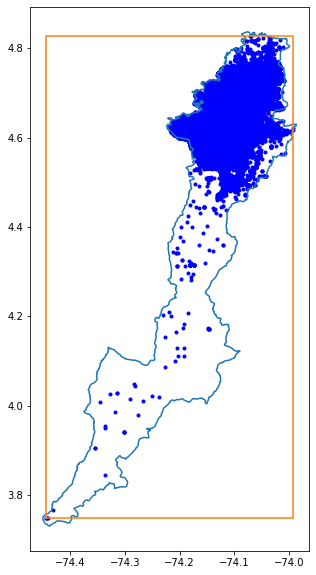

In [15]:
df_filtered = df
time_space_points, region = ProcessData.get_time_space_points(df_filtered, siedco_dict)
fig, ax = plt.subplots(figsize=(5,10))

ax.scatter(df_filtered.LONGITUD_X.values, df_filtered.LATITUD_Y.values, marker=".", color="blue")
ax.plot(*bogota_polygon.exterior.xy)
ax.plot(*get_polygon_rectangular_region(region).exterior.xy)


## RNMC

In [16]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_rnmc_12022020.csv'
rnmc_info = {'name':'RNMC','path':csv_path}

In [17]:
rnmc_dict = {
                'date': 'FECHA',
                'latitude': 'LATITUD',
                'longitude': 'LONGITUD',
                'time': 'HORA',
                'time_stamp':'TIME_STAMP'
            }

In [18]:
data = ProcessData('RNMC',csv_path)
df = data.get_formated_df()

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
df['TIME_STAMP'].sort_values(ascending=True)

0        2017-01-30 00:01:00
80       2017-01-30 00:01:00
128      2017-01-30 00:01:00
95       2017-01-30 00:01:00
39       2017-01-30 00:01:00
                 ...        
230977   2019-10-31 23:24:00
230978   2019-10-31 23:33:00
230979   2019-10-31 23:37:00
231036   2019-10-31 23:40:00
230980   2019-10-31 23:52:00
Name: TIME_STAMP, Length: 231117, dtype: datetime64[ns]

In [20]:
print(len(df))
print(df.shape)

231117
(231117, 32)


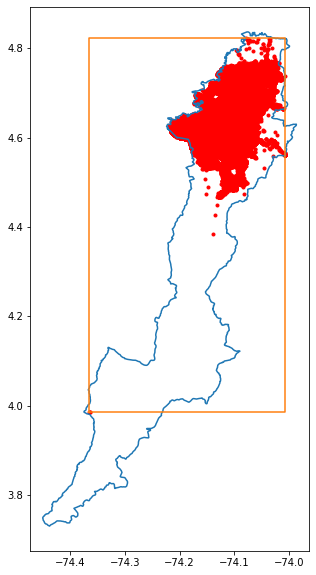

In [21]:
df_filtered = df
time_space_points, region = ProcessData.get_time_space_points(df_filtered, rnmc_dict)
fig, ax = plt.subplots(figsize=(5,10))

ax.scatter(df_filtered.LONGITUD.values, df_filtered.LATITUD.values, marker=".", color="red")
ax.plot(*bogota_polygon.exterior.xy)
ax.plot(*get_polygon_rectangular_region(region).exterior.xy)

## NUSE

In [21]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_nuse_11022020.csv'
rnmc_info = {'name':'NUSE','path':csv_path}

In [22]:
nuse_dict = {
                'date': 'FECHA',
                'latitude': 'LATITUD',
                'longitude': 'LONGITUD',
                'time': 'HORA',
                'time_stamp':'TIME_STAMP'
            }

In [23]:
data = ProcessData('NUSE',csv_path)
df = data.get_formated_df()

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
df['TIME_STAMP'].sort_values(ascending=True)

403684    2014-01-01 00:01:00
1566815   2014-01-01 00:01:00
403624    2014-01-01 00:01:00
58277     2014-01-01 00:03:00
720355    2014-01-01 00:04:00
                  ...        
1778370   2019-11-24 23:51:00
1717729   2019-11-24 23:51:00
651389    2019-11-24 23:55:00
1438707   2019-11-24 23:55:00
1214104   2019-11-24 23:57:00
Name: TIME_STAMP, Length: 2268394, dtype: datetime64[ns]

In [25]:
print(len(df))
print(df.shape)

2268394
(2268394, 22)


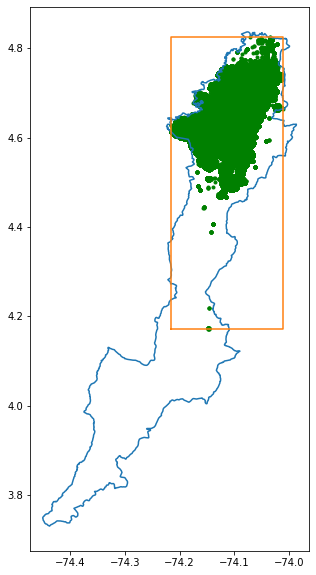

In [26]:
df_filtered = df
time_space_points, region = ProcessData.get_time_space_points(df_filtered, nuse_dict)
fig, ax = plt.subplots(figsize=(5,10))

ax.scatter(df_filtered.LONGITUD.values, df_filtered.LATITUD.values, marker=".", color="green")
ax.plot(*bogota_polygon.exterior.xy)
ax.plot(*get_polygon_rectangular_region(region).exterior.xy)

## There are not NUSE events on Ciudad Bolivar, Bosa and Usme?

### Actually, there are events on these localidaes...

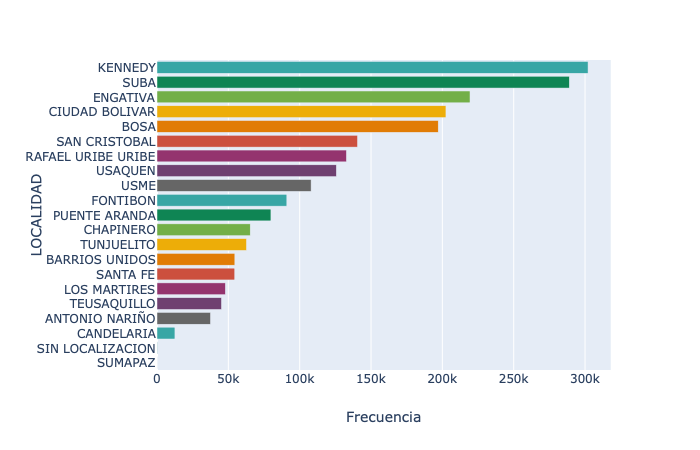

In [61]:
from IPython.display import Image
Image("../../profiles/nuse/figuras_nuse/localidades_freq_full_dataset.png")

### Actually, there are events on these localidaes but are not sparse:

In [49]:
## Localidad, Ciudad Bolívar
df_localidad = ProcessData.filter_by_field(df, 'LOCALIDAD', 'CIUDAD BOLIVAR')
localidad_polygon = get_localidad_polygon(localidades_polygons_list, 'CIUDAD BOLIVAR')

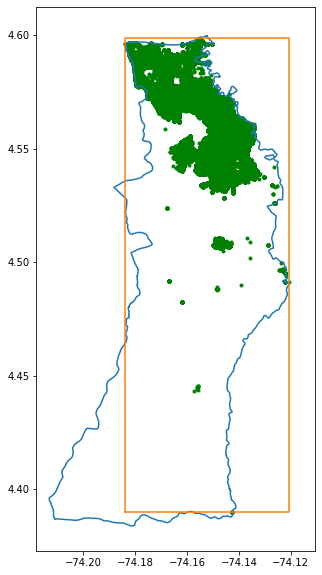

In [55]:
df_filtered = df_localidad
time_space_points, region = ProcessData.get_time_space_points(df_filtered, nuse_dict)
fig, ax = plt.subplots(figsize=(5,10))
ax.scatter(df_filtered.LONGITUD.values, df_filtered.LATITUD.values, marker=".", color="green")
ax.plot(*localidad_polygon.exterior.xy)
ax.plot(*get_polygon_rectangular_region(region).exterior.xy)


In [56]:
## Localidad, BOSA
df_localidad = ProcessData.filter_by_field(df, 'LOCALIDAD', 'BOSA')
localidad_polygon = get_localidad_polygon(localidades_polygons_list, 'BOSA')

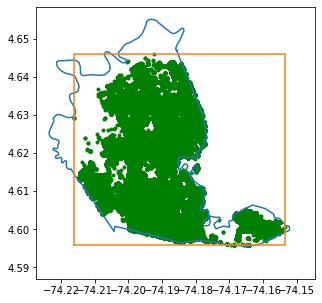

In [58]:
df_filtered = df_localidad
time_space_points, region = ProcessData.get_time_space_points(df_filtered, nuse_dict)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df_filtered.LONGITUD.values, df_filtered.LATITUD.values, marker=".", color="green")
ax.plot(*localidad_polygon.exterior.xy)
ax.plot(*get_polygon_rectangular_region(region).exterior.xy)


In [59]:
## Localidad, USME
df_localidad = ProcessData.filter_by_field(df, 'LOCALIDAD', 'USME')
localidad_polygon = get_localidad_polygon(localidades_polygons_list, 'USME')

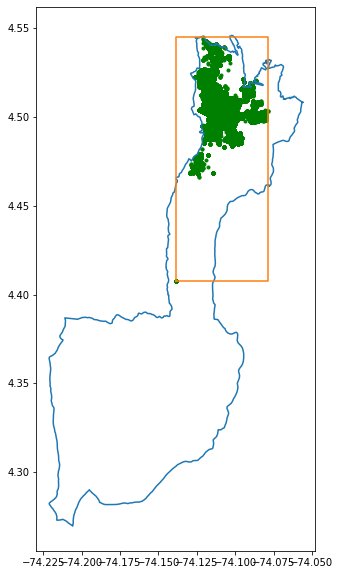

In [60]:
df_filtered = df_localidad
time_space_points, region = ProcessData.get_time_space_points(df_filtered, nuse_dict)
fig, ax = plt.subplots(figsize=(5,10))
ax.scatter(df_filtered.LONGITUD.values, df_filtered.LATITUD.values, marker=".", color="green")
ax.plot(*localidad_polygon.exterior.xy)
ax.plot(*get_polygon_rectangular_region(region).exterior.xy)
